In [176]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random
from scipy.stats import norm

In [177]:
from utils import *
from param_init import *
from exact_sol import *
from evaluation import *
from batching import *
from Adaptive_sampling import *
from Probability_algorithm import *


set_seed()

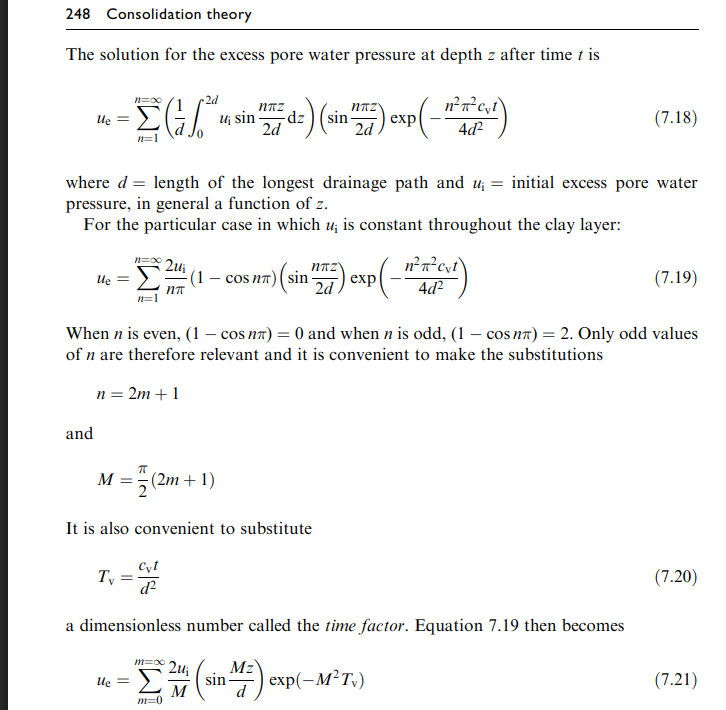

In [178]:
def analytical_excess_porepressure(time, z, delta_sigma, k, mv, H, terms=100):
    """
    Craig's Soil Mechanics, Seventh edition, Page 248
    Exact analytical solution for Terzaghi's 1D consolidation problem (double drainage).
    
    : time:         Time                                     (days)
    : z:            Depth                                    (m)
    : delta_sigma:  Applied vertical stress increment        (kPa)
    : k:            Coefficient of permeability              (m/day)
    : mv:           Coefficient of volume compressibility    (m^2/kN)
    : H:            Thickness of soil layer                  (m) 
    : terms:        Number of terms in the Fourier series
    : returns:      Excess pore water pressure u(z, t)       (kPa)
    """
    yw = 9.81         # unit weight of water (kN/m³)
    cv = k / (mv*yw)  # coefficient of consolidation (m²/day) 
    Tv= cv*time/H**2  # dimensionless time
    ue = 0.0
    for i in range (terms):
        M = np.pi/2* (2*i+1)
        ue+= 2*delta_sigma/M * np.sin(M*z/H) * np.exp(-M**2*Tv)
    return ue

In [179]:
def exact_degree_of_consolidation(time, k, mv, H, terms=100):
    """
    Craig's Soil Mechanics, Seventh edition, Page 250
    Exact analytical solution for Terzaghi's 1D consolidation problem (double drainage).
    
    : time:         Time                                     (days)
    : z:            Depth                                    (m)
    : delta_sigma:  Applied vertical stress increment        (kPa)
    : k:            Coefficient of permeability              (m/day)
    : mv:           Coefficient of volume compressibility    (m^2/kN)
    : H:            Thickness of soil layer                  (m) 
    : terms:        Number of terms in the Fourier series
    : returns:      Excess pore water pressure u(z, t)       (kPa)
    """
    cv = k / (9.81*mv)  # coefficient of consolidation (m²/s)
    Tv= cv*time/H**2 # dimensionless time
    U = 0.0
    for i in range(terms):
        M = np.pi/2* (2*i+1)
        U += 2/M**2 * np.exp(-M**2*Tv)
    return (1-U)

In [180]:
def exact_consolidation(U_t, delta_sigma, mv, H):
    """    
    : U_t:          Degree of consolidation                   (-)
    : delta_sigma:  Applied vertical stress increment        (kPa)
    : mv:           Coefficient of volume compressibility    (m^2/kN)
    : H:            Thickness of soil layer                  (m) 
    : returns:      
    """
    return delta_sigma * U_t * mv * H

In [181]:
from scipy.integrate import simpson 
def total_settlement(time, delta_sigma, k, mv, H, terms=100, num_points=1000):
    """
    Compute the total settlement at a given time by integrating effective stress
    calculated from excess pore pressure over the depth.

    : time:         Time (days)
    : delta_sigma:  Applied vertical stress increment (kPa)
    : k:            Coefficient of permeability (m/day)
    : mv:           Coefficient of volume compressibility (m²/kN)
    : H:            Thickness of the soil layer (m)
    : terms:        Number of Fourier terms
    : num_points:   Number of depth points to integrate over
    : returns:      Settlement s(t) in meters
    """
    z_vals = np.linspace(0, H, num_points)
    u_vals = np.array([analytical_excess_porepressure(time, z, delta_sigma, k, mv, H, terms) for z in z_vals])
    
    # Effective stress = delta_sigma - u
    effective_stress = delta_sigma - u_vals

    # Integrate effective stress over depth to get strain, then multiply by mv
    settlement = mv * simpson(effective_stress, x=z_vals)  # or np.trapz

    return settlement

In [182]:
specs = {
    't': {'range': 10.0},  # Range of time (used for time sweep / normalization)

    'load': {
        'mean': 1.0,       # Applied vertical stress in kPa scaled down to 1.0
        'std': 10.0,         # ~10% is realistic for construction load variability
        'lower_multiplier': -5,
        'upper_multiplier': 5
    },

    'k': {
        'mean': 7e-5,        # m/s (about 2.2 m/year – soft to medium clay)
        'std': 1.5e-5,       # ~20% std dev is common in lab tests for permeability
        'lower_multiplier': -5,
        'upper_multiplier': 5
    },

    'mv': {
        'mean': 1e-3,        # m²/kN (typical for Norwegian marine clay)
        'std': 2e-4,         # ~20% variation due to sample disturbance and strain level
        'lower_multiplier': -5,
        'upper_multiplier': 5
    },

    'H': {
        'mean': 10.0,        # m
        'std': 0.5,          # ~5% deviation due to stratigraphy or measurement error
        'lower_multiplier': -5,
        'upper_multiplier': 5
    }
}

In [183]:
# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [184]:
class PINN_vanilla_terzaghi(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super().__init__()
        layers = [nn.Linear(6, hidden_size), nn.Tanh()]
        for _ in range(hidden_layers):
            layers += [nn.Linear(hidden_size, hidden_size), nn.Tanh()]
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, z, load, k, mv, H):
        # t, m, mu, k, y0, v0 each have shape (..., 1)
        orig_shape = t.shape        # e.g. (Nt,1) or (B,Nt,1)
        # compute batch_size = product of all dims except the last one
        batch_size = math.prod(orig_shape[:-1])  # pure-Python, no .item()

        # flatten all leading dims into one
        def flatten(x):
            return x.reshape(batch_size, -1)  # -1 is the feature dim (1)

        t_flat  = flatten(t)
        z_flat  = flatten(z)
        load_flat = flatten(load)
        k_flat  = flatten(k)
        mv_flat = flatten(mv)
        H_flat  = flatten(H)
        
        # concatenate features -> (batch_size, 6)
        x_flat = torch.cat([t_flat, z_flat, load_flat, k_flat, mv_flat, H_flat], dim=1)
        
        # single pass through the MLP
        ue_flat = self.net(x_flat)       # (batch_size, 1)
        
        # reshape back to original (..., 1)
        return ue_flat.view(*orig_shape)
    
def pde_loss_terzaghi(u_pred, t, z, k, mv, H, norm_info=None):
    # First, compute the derivatives of the model output using the (normalized) inputs.
    u_t_norm = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_z_norm = torch.autograd.grad(u_pred, z, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_zz_norm = torch.autograd.grad(u_z_norm, z, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]

    # If norm_info is provided, denormalize the parameters for the PDE residual.
    if norm_info is not None:
        k_phys = z_score_denormalize(k, norm_info['k']) if 'k' in norm_info else k.detach()
        mv_phys = z_score_denormalize(mv, norm_info['mv']) if 'mv' in norm_info else mv.detach()
        H_phys = z_score_denormalize(H, norm_info['H']) if 'H' in norm_info else H.detach()

        dt_dt_hat = norm_info['t']['range'] #Scaling the time collocation points to the physical time range using chain rule.
        u_t = u_t_norm / dt_dt_hat
        dt_dz_hat = H_phys
        u_zz = u_zz_norm / dt_dz_hat**2 #Scaling the depth collocation points to the physical depth range using chain rule.

    else:
        u_t = u_t_norm
        u_zz = u_zz_norm

        k_phys = k
        mv_phys = mv
        H_phys = H

    yw = 9.81        # unit weight of water (kN/m³)
    # Compute the PDE residual using physical parameters.

    residual = u_t - k_phys/(mv_phys*yw) * u_zz
    return torch.mean(residual**2)

def boundary_loss_terzaghi(u_pred_z0, u_pred_z1, z1, H, norm_info=None):
    # Compute the gradient of the model output with respect to time
    u_z1_norm = torch.autograd.grad(u_pred_z1, z1, grad_outputs=torch.ones_like(u_pred_z1), create_graph=True)[0]

    if norm_info is not None and 'H' in norm_info:
        H_phys = z_score_denormalize(H, norm_info['H'])
        dt_dz_hat = H_phys #Scaling the time collocation points to the physical time range using chain rule.
        u_z1= u_z1_norm / dt_dz_hat

    # Compute the boundary loss using physical parameters.
    return torch.mean(u_pred_z0**2) + torch.mean(u_z1**2)

# Compute boundary loss
def initital_loss_terzaghi(u_pred_t0, load, norm_info=None):
    if norm_info is not None and 'load' in norm_info:
        load_phys = z_score_denormalize(load, norm_info['load'])
    else:
        load_phys = load
    return torch.mean((u_pred_t0-load_phys)**2)


# Trainer class to manage training process
class Trainer_terzaghi:
    def __init__(self, model, optimizer, epochs=4001, lambda_residual = 1.0, lambda_ic = 1.0, lambda_bc=10.0, lambda_data=1.0, datapoints = None, u_exact_datapoints=None):

        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        if os.path.exists("loss_history.npy"): 
            self.losses = np.load("loss_history.npy", allow_pickle=True).tolist()
        else:
            self.losses = {"Residual Loss": [], "Boundary Loss": [], "Initial Loss":[], "Data Loss": []}
        self.lambda_residual = lambda_residual
        self.lambda_ic = lambda_ic
        self.lambda_bc = lambda_bc
        self.lambda_data = lambda_data
        self.datapoints = datapoints
        self.u_exact_datapoints = u_exact_datapoints

    def train(self, *args):
        # Allow only passing a single dictionary as argument

        params = args[0]
        t_coll = params['t_coll']
        z_coll = params['z_coll']
        load = params['load']
        k  = params['k']
        mv = params['mv']
        H  = params['H']
        t0 = params['t0']
        z0 = params['z0']
        z1 = params['z1']
        # define the norm_info dictionary if it exists in params
        norm_info = params.get('norm_info', None)

        # Initialize best loss so far
        # if all three lists are empty, use +∞
        if not any(self.losses.values()):
            best_loss = float("inf")
        else:
            # otherwise grab last entry or 0.0
            res_last  = self.losses["Residual Loss"][-1]  if self.losses["Residual Loss"] else 0.0
            ic_loss  = self.losses["Initial Loss"][-1]     if self.losses["Initial Loss"] else 0.0
            bc_last   = self.losses["Boundary Loss"][-1]  if self.losses["Boundary Loss"] else 0.0
            data_last = self.losses["Data Loss"][-1]      if self.losses["Data Loss"] else 0.0

            best_loss = (
                res_last  * self.lambda_residual +
                ic_loss   * self.lambda_ic +
                bc_last   * self.lambda_bc +
                data_last * self.lambda_data
            )

        for epoch in range(self.epochs):
            self.optimizer.zero_grad()

            u_pred = self.model(t_coll, z_coll, load, k, mv, H)
            u_pred_t0 = self.model(t0, z_coll, load, k, mv, H)
            u_pred_z0 = self.model(t_coll, z0, load, k, mv, H)
            u_pred_z1 = self.model(t_coll, z1, load, k, mv, H)

            # Compute the losses
            loss_pde = pde_loss_terzaghi(u_pred, t_coll, z_coll, k, mv, H, norm_info)
            loss_ic = initital_loss_terzaghi(u_pred_t0, load, norm_info)
            loss_bc = boundary_loss_terzaghi(u_pred_z0, u_pred_z1, z1, H, norm_info)

            self.losses["Residual Loss"].append(loss_pde.item())
            self.losses["Initial Loss"].append(loss_ic.item())
            self.losses["Boundary Loss"].append(loss_bc.item())

            # If data loss is provided, add it to the total loss
            if self.datapoints is not None and self.u_exact_datapoints is not None:
                loss_data = data_loss(self.model, self.datapoints, self.u_exact_datapoints, norm_info, lambda_data=self.lambda_data) ## FIX THIS§!!
                self.losses["Data Loss"].append(loss_data.item())
                loss = loss_pde * self.lambda_residual + self.lambda_bc * loss_bc + loss_ic * self.lambda_ic + loss_data * self.lambda_data
            else:
                # If no data loss is provided, just use the PDE and boundary losses
                loss = loss_pde * self.lambda_residual + loss_bc * self.lambda_bc + loss_ic * self.lambda_ic
            loss.backward()
            self.optimizer.step()

            current_loss = loss.item()
            if current_loss < best_loss:
                best_loss = current_loss

            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, PDE loss: {loss_pde.item()}, BC loss: {loss_bc.item()}, IC loss: {loss_ic.item()}")
                plot_loss(self.losses)
                np.save("loss_history.npy", self.losses)
        print(f"Phase 1 complete. Best loss so far: {best_loss}")

        # Phase 2: Continue training until an epoch is reached with loss below the best_loss from Phase 1.
        extra_epochs = 0
        while True:
            self.optimizer.zero_grad()

            u_pred = self.model(t_coll, z_coll, load, k, mv, H)
            u_pred_t0 = self.model(t0, z_coll, load, k, mv, H)
            u_pred_z0 = self.model(t_coll, z0, load, k, mv, H)
            u_pred_z1 = self.model(t_coll, z1, load, k, mv, H)
            # Compute the losses
            loss_pde = pde_loss_terzaghi(u_pred, t_coll, z_coll, k, mv, H, norm_info)
            loss_ic = initital_loss_terzaghi(u_pred_t0, load, norm_info)
            loss_bc = boundary_loss_terzaghi(u_pred_z0, u_pred_z1, z1, H, norm_info)
            
            self.losses["Residual Loss"].append(loss_pde.item())
            self.losses["Initial Loss"].append(loss_ic.item())
            self.losses["Boundary Loss"].append(loss_bc.item())

            # If data loss is provided, add it to the total loss
            if self.datapoints is not None and self.u_exact_datapoints is not None:
                loss_data = data_loss(self.model, self.datapoints, self.u_exact_datapoints, norm_info, lambda_data=self.lambda_data) ## FIX THIS§!!
                self.losses["Data Loss"].append(loss_data.item())
                loss = loss_pde * self.lambda_residual + self.lambda_bc * loss_bc + loss_ic * self.lambda_ic + loss_data * self.lambda_data
            else:
                # If no data loss is provided, just use the PDE and boundary losses
                loss = loss_pde * self.lambda_residual + loss_bc * self.lambda_bc + loss_ic * self.lambda_ic
            
            loss.backward()
            self.optimizer.step()

            extra_epochs += 1
            epoch += 1
            current_loss = loss.item()

            if extra_epochs % 1000 == 0:
                print(f"Extra Epoch {extra_epochs}, PDE loss: {loss_pde.item()}, BC loss: {loss_bc.item()}, IC loss: {loss_ic.item()}")
                plot_loss(self.losses)
                np.save("loss_history.npy", self.losses)
            if current_loss < best_loss:
                print(f"Improved loss found: {current_loss} (after {extra_epochs} extra epochs)")
                plot_loss(self.losses)
                np.save("loss_history.npy", self.losses)
                break

In [185]:
# Run training pipeline
params=initialize_param(500,distribute=[],specs=specs, normalize=True, terzaghi=True)
#,'k','y0','v0'

# I only normalize the input parameters that are diustributed. That means that if training on all params, it expects 0 for mean. But if I change distribute to only 
# some params, I need to change the mean of the other params to 0 for it to be correct. 
print(params)
print(params['norm_info'])

{'norm_info': {'t': {'range': 10.0}, 'load': {'mean': 1.0, 'std': 10.0}, 'k': {'mean': 7e-05, 'std': 1.5e-05}, 'mv': {'mean': 0.001, 'std': 0.0002}, 'H': {'mean': 10.0, 'std': 0.5}}, 't_coll': tensor([[0.8823],
        [0.9150],
        [0.3829],
        [0.9593],
        [0.3904],
        [0.6009],
        [0.2566],
        [0.7936],
        [0.9408],
        [0.1332],
        [0.9346],
        [0.5936],
        [0.8694],
        [0.5677],
        [0.7411],
        [0.4294],
        [0.8854],
        [0.5739],
        [0.2666],
        [0.6274],
        [0.2696],
        [0.4414],
        [0.2969],
        [0.8317],
        [0.1053],
        [0.2695],
        [0.3588],
        [0.1994],
        [0.5472],
        [0.0062],
        [0.9516],
        [0.0753],
        [0.8860],
        [0.5832],
        [0.3376],
        [0.8090],
        [0.5779],
        [0.9040],
        [0.5547],
        [0.3423],
        [0.6343],
        [0.3644],
        [0.7104],
        [0.9464],
        [0.7890

In [186]:
vanilla_model = PINN_vanilla_terzaghi(hidden_size=20, hidden_layers=3)

if os.path.exists("loss_history.npy"):
    os.remove("loss_history.npy")

Epoch 0, PDE loss: 1.2347894880804233e-05, BC loss: 0.0005976436077617109, IC loss: 0.9834054708480835


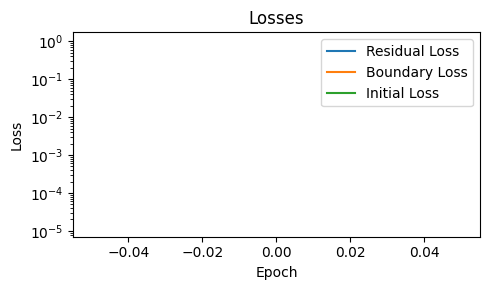

Epoch 1000, PDE loss: 2.9178004297136795e-06, BC loss: 0.00019820411398541182, IC loss: 0.019416917115449905


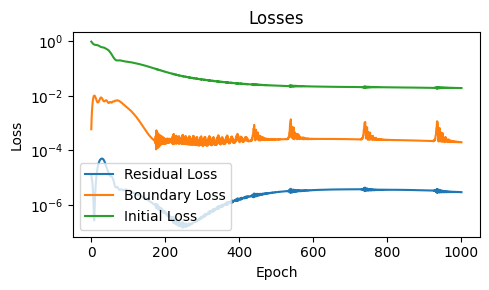

Epoch 2000, PDE loss: 9.67337541624147e-07, BC loss: 6.649384158663452e-05, IC loss: 0.011517547070980072


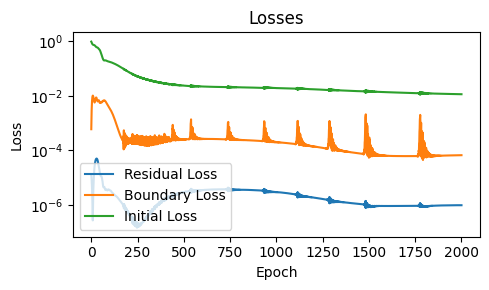

Epoch 3000, PDE loss: 8.613451996097865e-07, BC loss: 5.571906149270944e-05, IC loss: 0.008769487962126732


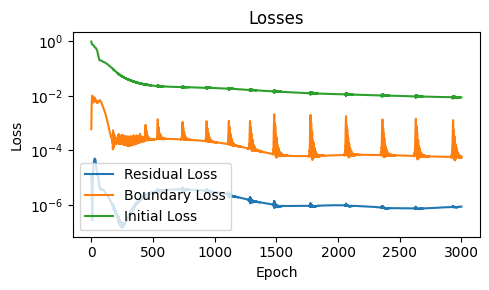

Epoch 4000, PDE loss: 1.037116476254596e-06, BC loss: 5.063390199211426e-05, IC loss: 0.007545355707406998


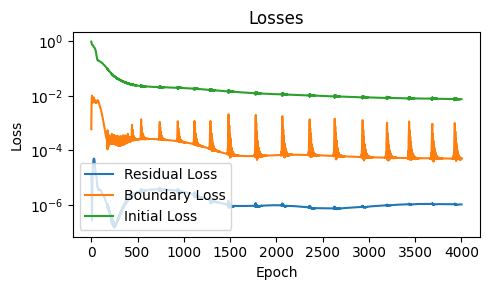

Phase 1 complete. Best loss so far: 0.009088811464607716
Improved loss found: 0.009085271507501602 (after 1 extra epochs)


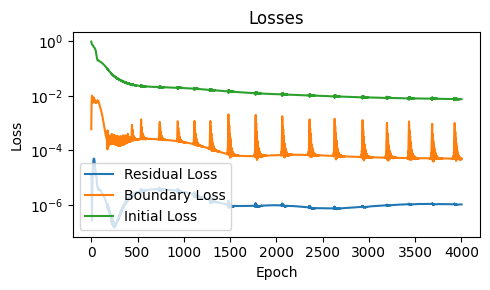

In [187]:
optimizer = optim.Adam(vanilla_model.parameters(), lr=0.001)
trainer = Trainer_terzaghi(vanilla_model, optimizer,epochs=4001, lambda_residual=1000)
trainer.train(params)

In [172]:
def make_input_params(z_test, values, norm_info=None):
    ''' 
    Makes test parameters for input to the PINN model.
    
    Args:
        t_test: a numpy array of time points to evaluate the model at.
        z_test: a numpy array of depth points to evaluate the model at.
        values: a list of physical values in the order [load, k, mv, H].
        norm_info: a dictionary with normalization information.
    
    Returns:
        A tuple of torch tensors (load, k, mv, H) with shape (len(t_test), 1).
    '''
    values = values.copy()

    
    if norm_info is not None:
        values[0] = z_score_normalize(values[0], norm_info['load']) if 'load' in norm_info else values[0]
        values[1] = z_score_normalize(values[1], norm_info['k']) if 'k' in norm_info else values[1]
        values[2] = z_score_normalize(values[2], norm_info['mv']) if 'mv' in norm_info else values[2]
        values[3] = z_score_normalize(values[3], norm_info['H']) if 'H' in norm_info else values[3]

    load = torch.tensor([values[0]] * len(z_test), dtype=torch.float32).view(-1, 1)
    k = torch.tensor([values[1]] * len(z_test), dtype=torch.float32).view(-1, 1)
    mv = torch.tensor([values[2]] * len(z_test), dtype=torch.float32).view(-1, 1)
    H = torch.tensor([values[3]] * len(z_test), dtype=torch.float32).view(-1, 1)
    return load, k, mv, H

In [173]:
N = 100

z_test = np.linspace(0, 10, N)  # depth points to evaluate the model at
z_coll = torch.linspace(0, 1, N).view(-1,1) 

test_values = [
    specs['load']['mean'],
    specs['k']['mean'],
    specs['mv']['mean'],
    specs['H']['mean'] + specs['H']['std'] * 0  # Adding some noise to H
]
input_test_params = make_input_params(z_test, test_values, params['norm_info'])
print(test_values)

[1.0, 7e-05, 0.001, 10.0]


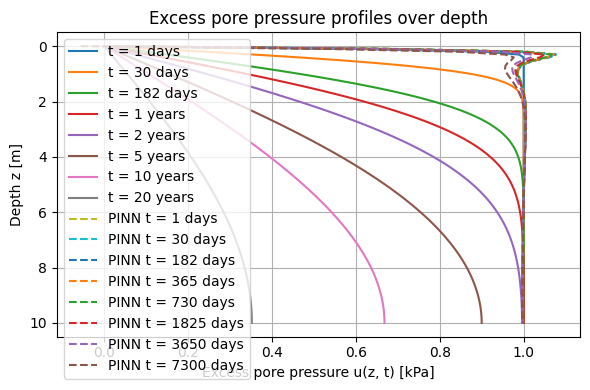

In [175]:
times = [1, 30, 182, 365, 2 * 365, 5 * 365, 10 * 365, 20 * 365]

# Create a new figure
plt.figure(figsize=(6, 4))

# Compute and plot pore pressure profiles over depth for each time
for i in range(len(times)):
    u_vals = analytical_excess_porepressure(times[i], z_test, *test_values)
    label = f"t = {times[i] // 365} years" if times[i] >= 365 else f"t = {times[i]} days"
    plt.plot(u_vals, z_test, label=label)

# Compute and plot pore pressure profiles using the PINN model
for time in times:
    time_tensor = torch.tensor([time/365/10], dtype=torch.float32).view(-1, 1)
    expanded_time_tensor = time_tensor.expand_as(z_coll)
    u_pred = vanilla_model(
        expanded_time_tensor,
        z_coll,
        *input_test_params
    ).detach().numpy()
    plt.plot(u_pred, z_test, label=f"PINN t = {time} days", linestyle='--')

# Add labels, title, and legend
plt.xlabel("Excess pore pressure u(z, t) [kPa]")
plt.ylabel("Depth z [m]")
plt.title("Excess pore pressure profiles over depth")
plt.grid(True)
plt.legend()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.tight_layout()
plt.show()

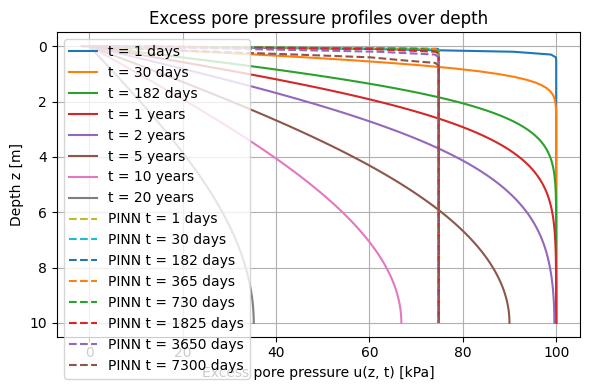

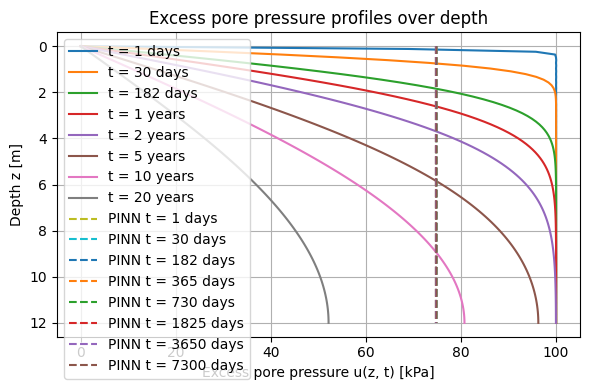



In [ ]:
N = 1

z_test = np.linspace(0, 10, N)  # Time points to evaluate the model at
z_coll = torch.linspace(0, 10, N).view(-1,1) / specs['t']['range']  # Time points for collocation

test_values = [
    specs['load']['mean'],
    specs['k']['mean'],
    specs['mv']['mean'],
    specs['H']['mean']
]

z_coll = torch.linspace(5, specs['H']['mean'], N).view(-1,1)  # Depth points for collocation
input_params = make_input_params(t_test, z_coll, test_values, norm_info=params['norm_info'])

print(input_params)
vanilla_model(t_coll, z_coll, *input_params)

(tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]))


tensor([[-0.0052]], grad_fn=<ViewBackward0>)

In [31]:
t = 1.0  # time in days
z = 5.0  # depth in meters
delta_sigma = np.random.normal(specs['load']['mean'], specs['load']['std'])  # applied vertical stress increment in kPa
k = np.random.normal(specs['k']['mean'], specs['k']['std'])  # coefficient of permeability in m/day
mv = np.random.normal(specs['mv']['mean'], specs['mv']['std'])  # coefficient of volume compressibility in m²/kN
H = np.random.normal(specs['H']['mean'], specs['H']['std'])  # thickness of soil layer in m
terms = 100  # number of terms in the Fourier series

In [32]:
exact_porepressure = analytical_excess_porepressure(365, z, delta_sigma, k, mv, H, terms)
exact_degree = exact_degree_of_consolidation(365, k, mv, H, terms)
exact_consolidation_height = exact_consolidation(exact_degree, delta_sigma, mv, H)

print(f"Exact pore pressure: {exact_porepressure:.5f} kPa")
print(f"Exact degree of consolidation: {exact_degree:.5f} (-)")
print(f"Exact consolidation: {exact_consolidation_height:.18f} kPa")

total_settlement_value = total_settlement(365, delta_sigma, k, mv, H, terms=10)
print(total_settlement_value)

Exact pore pressure: 103.06745 kPa
Exact degree of consolidation: 0.15684 (-)
Exact consolidation: 0.200119246570618414 kPa
0.20011924657163088


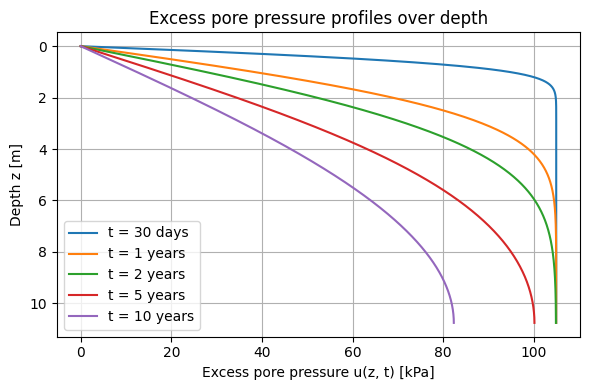

In [33]:
times = [30, 365, 2 * 365, 5 * 365, 10 * 365]  # Convert years to days
z_vals = np.linspace(0, H, 600)

# Create a new figure
plt.figure(figsize=(6, 4))

# Compute and plot pore pressure profiles over depth for each time
for i in range(len(times)):
    u_vals = [analytical_excess_porepressure(times[i], z, delta_sigma, k, mv, H) for z in z_vals]
    label = f"t = {times[i] // 365} years" if times[i] >= 365 else f"t = {times[i]} days"
    plt.plot(u_vals, z_vals, label=label)

# Add labels, title, and legend
plt.xlabel("Excess pore pressure u(z, t) [kPa]")
plt.ylabel("Depth z [m]")
plt.title("Excess pore pressure profiles over depth")
plt.grid(True)
plt.legend()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.tight_layout()
plt.show()

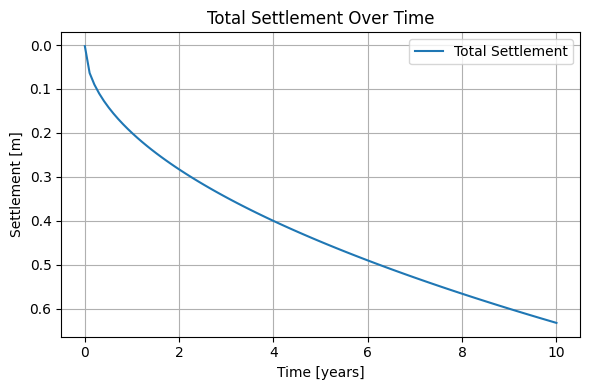

Total settlement: 0.63228 m


In [34]:
# Generate settlement values over time using exact_degree_of_consolidation and exact_consolidation
time_range = np.linspace(0, 10*365, 100)  # Time in days (0 to 10 years)
degree_of_consolidation_values = [exact_degree_of_consolidation(t, k, mv, H, terms=100) for t in time_range]
settlement_values = [exact_consolidation(U_t, delta_sigma, mv, H) for U_t in degree_of_consolidation_values]

# Create the plot
plt.figure(figsize=(6, 4))
plt.plot(time_range/365, settlement_values, label="Total Settlement")

# Add labels, title, and grid
plt.xlabel("Time [years]")
plt.ylabel("Settlement [m]")
plt.title("Total Settlement Over Time")
plt.grid(True)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.legend()
plt.tight_layout()
plt.show()
print("Total settlement:", f"{settlement_values[-1]:.5f}", "m")

In [35]:
t = 1.0  # time in days
z = 5.0  # depth in meters
delta_sigma = np.random.normal(specs['load']['mean'], specs['load']['std'])  # applied vertical stress increment in kPa
k = np.random.normal(specs['k']['mean'], specs['k']['std'])  # coefficient of permeability in m/day
mv = np.random.normal(specs['mv']['mean'], specs['mv']['std'])  # coefficient of volume compressibility in m²/kN
H = np.random.normal(specs['H']['mean'], specs['H']['std'])  # thickness of soil layer in m
terms = 100  # number of terms in the Fourier series